In [10]:
import tensorflow as tf

In [11]:
BATCH_SIZE = 64

In [12]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

val_images = train_images[-10000:]
val_labels = train_labels[-10000:]
train_images = train_images[:-10000]
train_labels = train_labels[:-10000]

TRAIN_IMG_COUNT = train_labels.shape[0]
VAL_IMG_COUNT = val_labels.shape[0]
print(train_labels.shape)
print(val_labels.shape)

(40000, 1)
(10000, 1)


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE ## Auto tune tf.data hyper parameters for 

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str): ## if caching to a file
            ds = ds.cache(cache)
        else: ## cache in memory
            ds = ds.cache()
    ## shuffle data, otherwise, data will be cached with the same patten (not random)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [14]:
train_labels_onehot =  tf.keras.utils.to_categorical(train_labels, 10)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, 10)
print(train_labels.shape)
train_ds_tensor = tf.data.Dataset.from_tensor_slices((train_images, train_labels_onehot))
val_ds_tensor = tf.data.Dataset.from_tensor_slices((val_images, val_labels_onehot))

train_ds = prepare_for_training(train_ds_tensor)
val_ds = prepare_for_training(val_ds_tensor)

for d in train_ds.take(1):
    print(d[1].shape)


(40000, 1)
(64, 10)


In [15]:
model = tf.keras.Sequential()
'''
# A lambda layer to resize the image
model.add(tf.keras.layers.Lambda( 
    lambda image: tf.image.resize( 
        image, 
        (32, 32), 
        method = tf.image.ResizeMethod.BICUBIC,
        preserve_aspect_ratio = True
    )
))
'''
# model.add(tf.keras.layers.Input((32, 32, 3)))

features = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(32, 32, 3), pooling=None,
)


# count = 0
N =  len(features.layers) # -1 # 6 # len(features.layers) # Number of layers we want to freeze or finetune, N = -1 reinit all conv layers
# N = len(features.layers) to freeze or finetune all layers
is_training = True # Set true to finetune
new_layers = list()
set_random = False # Set false for fine tuning
# Layer initialisation method:
initializer = tf.keras.initializers.GlorotUniform()# tf.keras.initializers.GlorotNormal()#tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

# exclude the input layer, since our new input size is 32,32
for count, layer in enumerate(features.layers[1:]):
    if count <= N:
        if layer.trainable:
            layer.trainable = is_training
            print(layer, layer.trainable, count)
    else:
        if set_random:
            print("Setting random weights")
            # check if conv layer, since conv layer has len =2,since weights and biases
            if len(layer.get_weights()) > 1: 
                # get the filter shapes
                weight_shape = layer.get_weights()[0].shape
                bias_shape = layer.get_weights()[1].shape
                # initialise the parameters
                init_weights = initializer(weight_shape)
                init_bias = initializer(bias_shape)
                # set the new parameters
                layer.set_weights([init_weights, init_bias]) # try commenting to see the assertion error
                # check if they set correct by asserting the:
                # weights
                tf.debugging.assert_equal(layer.get_weights()[0], init_weights)
                tf.debugging.assert_equal(layer.get_weights()[1], init_bias)
                # Make sure the layer is trainable
                layer.trainable = True
                
            
    new_layers.append(layer)
    # count += 1

# Build a new model with the new layers
new_features = tf.keras.Sequential(new_layers)
model.add(new_features)
#model.add(tf.keras.layers.AveragePooling2D((4,4)))
flatten = tf.keras.layers.Flatten()
fc1 = tf.keras.layers.Dense(4096)
fc2 = tf.keras.layers.Dense(4096)
cifar10_head = tf.keras.layers.Dense(10, activation="softmax")
 
model.add(flatten)
model.add(fc1)
model.add(fc2)
model.add(cifar10_head)

inp = tf.random.normal((1, 32, 32, 3))
model(inp)
model.summary()

<keras.layers.convolutional.Conv2D object at 0x7f427eef4910> True 0
<keras.layers.convolutional.Conv2D object at 0x7f427eedbf10> True 1
<keras.layers.pooling.MaxPooling2D object at 0x7f43603d1710> True 2
<keras.layers.convolutional.Conv2D object at 0x7f427ee89450> True 3
<keras.layers.convolutional.Conv2D object at 0x7f43701c24d0> True 4
<keras.layers.pooling.MaxPooling2D object at 0x7f427ee86b90> True 5
<keras.layers.convolutional.Conv2D object at 0x7f427ee926d0> True 6
<keras.layers.convolutional.Conv2D object at 0x7f427ee959d0> True 7
<keras.layers.convolutional.Conv2D object at 0x7f42808b8a90> True 8
<keras.layers.pooling.MaxPooling2D object at 0x7f427ee8e390> True 9
<keras.layers.convolutional.Conv2D object at 0x7f427eea5e90> True 10
<keras.layers.convolutional.Conv2D object at 0x7f427eed15d0> True 11
<keras.layers.convolutional.Conv2D object at 0x7f427eea7bd0> True 12
<keras.layers.pooling.MaxPooling2D object at 0x7f427eeb1510> True 13
<keras.layers.convolutional.Conv2D object at

In [16]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

opt = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Prepare the model for training
model.compile(optimizer=opt, # Stochastic gradient descent optimiser
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # Crossentropy loss
              metrics=METRICS
             ) # Accuracy measure

In [17]:
'''
# Train the model
history = model.fit(
  x=train_images, # Model inputs
  y=train_labels, # True labels for error
  batch_size=32,  # Training batch size; How many samples per time we feed in
  epochs=10,      # Number of epochs, or how many times we go trough the entire dataset to update the parameters
  validation_data=(val_images, val_labels) # Validation inputs and true lables
)
'''

'\n# Train the model\nhistory = model.fit(\n  x=train_images, # Model inputs\n  y=train_labels, # True labels for error\n  batch_size=32,  # Training batch size; How many samples per time we feed in\n  epochs=10,      # Number of epochs, or how many times we go trough the entire dataset to update the parameters\n  validation_data=(val_images, val_labels) # Validation inputs and true lables\n)\n'

In [18]:
## To prevent the model from becoming worst (e.g. overfitting) stop the training before the issues start using the Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=30,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    callbacks=[early_stopping_cb]
)


Epoch 1/30
625/625 [==============================] - 60s 93ms/step - loss: 1.3490 - categorical_accuracy: 0.5264 - precision: 0.7361 - recall: 0.3371 - val_loss: 0.9506 - val_categorical_accuracy: 0.6605 - val_precision: 0.7775 - val_recall: 0.5451
Epoch 2/30
625/625 [==============================] - 58s 92ms/step - loss: 0.8786 - categorical_accuracy: 0.6936 - precision: 0.7905 - recall: 0.5957 - val_loss: 0.7728 - val_categorical_accuracy: 0.7288 - val_precision: 0.8159 - val_recall: 0.6392
Epoch 3/30
625/625 [==============================] - 57s 92ms/step - loss: 0.7531 - categorical_accuracy: 0.7366 - precision: 0.8146 - recall: 0.6580 - val_loss: 0.8006 - val_categorical_accuracy: 0.7134 - val_precision: 0.7847 - val_recall: 0.6425
Epoch 4/30
625/625 [==============================] - 58s 93ms/step - loss: 0.6721 - categorical_accuracy: 0.7663 - precision: 0.8355 - recall: 0.6979 - val_loss: 0.6794 - val_categorical_accuracy: 0.7626 - val_precision: 0.8274 - val_recall: 0.6981


In [19]:
predictions = model.predict(test_images)

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred_labels = np.argmax(predictions, 1)
print(pred_labels.shape)

(10000,)


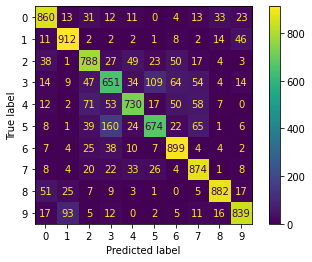

In [21]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall'])


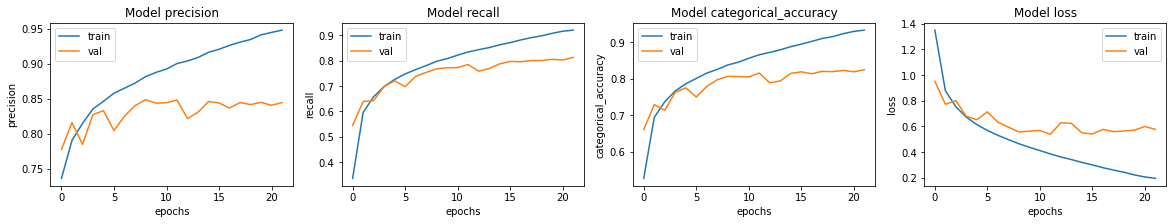

In [22]:
## visualize the performance
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
print(history.history.keys())
for i, met in enumerate(['precision', 'recall', 'categorical_accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

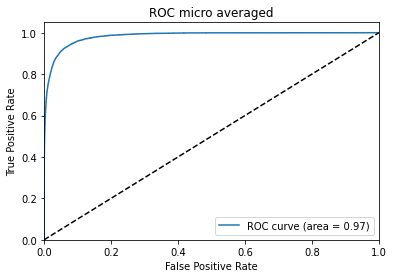

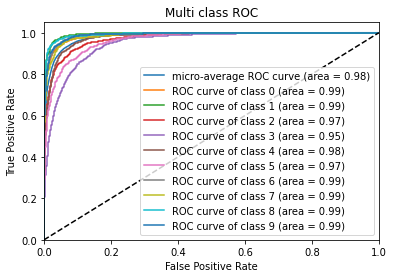

In [23]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

## ROC curve plotting
# https://scikit-learn.org/0.15/auto_examples/plot_roc.html

# one hot test labels
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, 10)
n_classes = 10

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_onehot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_onehot.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC micro averaged')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi class ROC')
plt.legend(loc="lower right")
plt.show()